# Preprocessing, EDA, feature engineering

data source: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data

### About the data

- data gathered at two solar power plants in India over period of 34 days
- two pairs of files: each pair with power generation data and sensor reading dataset
- power generation data gathered at the inverter level at 15 min. intervals - each inverter has multiple lines of solar panels attached to it
- sensor data is gathered at plant level - single array of sensors optimally placed at plant

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import sagemaker
import boto3
from dotenv import load_dotenv
import os

In [75]:
load_dotenv() # .env wit AWS configure and bucket name

boto_session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    aws_session_token=os.getenv("AWS_SESSION_TOKEN"),
    region_name=os.getenv("AWS_DEFAULT_REGION"),
)

s3 = boto_session.client("s3")
bucket = os.getenv("S3_BUCKET")

p1gen_file_path = "data/Plant_1_Generation_Data.csv"
p2gen_file_path = "data/Plant_2_Generation_Data.csv"
p1weather_file_path = "data/Plant_1_Weather_Sensor_Data.csv"
p2weather_file_path = "data/Plant_2_Weather_Sensor_Data.csv"

s3.download_file(bucket, p1gen_file_path, p1gen_file_path)
s3.download_file(bucket, p2gen_file_path, p2gen_file_path)
s3.download_file(bucket, p1weather_file_path, p1weather_file_path)
s3.download_file(bucket, p2weather_file_path, p2weather_file_path)

p1gen = pd.read_csv(p1gen_file_path)
p2gen = pd.read_csv(p2gen_file_path)
p1weather = pd.read_csv(p1weather_file_path)
p2weather = pd.read_csv(p2weather_file_path)

[01/23/25 15:41:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=453868;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=765269;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/23/25 15:41:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=228026;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=456667;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/23/25 15:41:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=981157;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=603091;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=619825;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=794764;file:///home/vscode/.local/lib/python3.12/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

In [76]:
# format datetime
p1gen["DATE_TIME"] = pd.to_datetime(p1gen["DATE_TIME"], format="%d-%m-%Y %H:%M")
p2gen["DATE_TIME"] = pd.to_datetime(p2gen["DATE_TIME"], format="%Y-%m-%d %H:%M:%S")
p1weather['DATE_TIME']= pd.to_datetime(p1weather['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
p2weather['DATE_TIME']= pd.to_datetime(p2weather['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

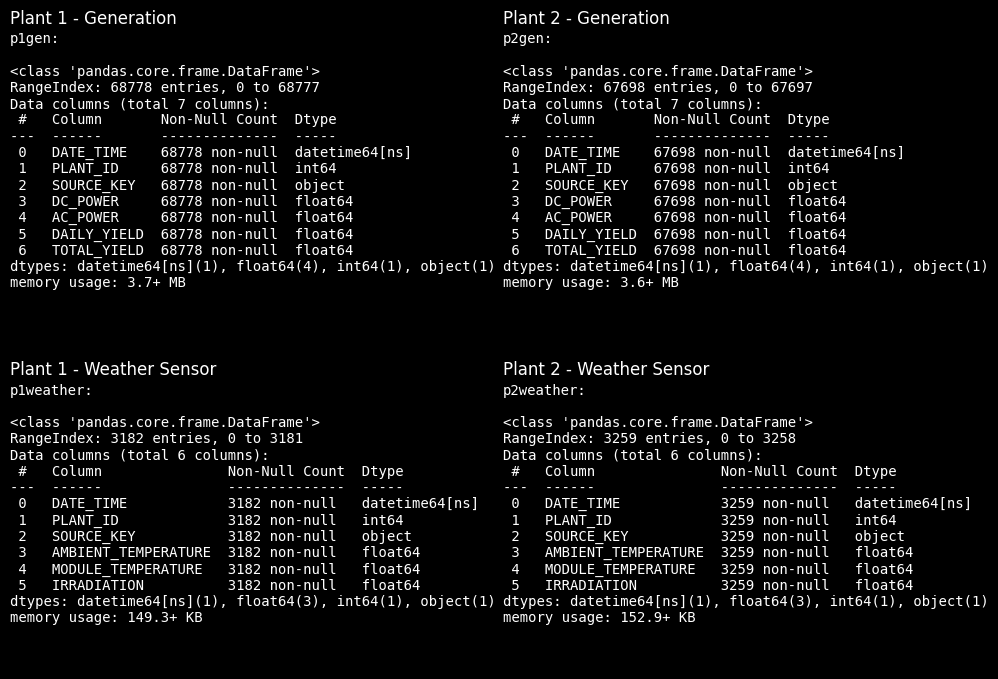

In [77]:
def get_info_text(df):
    buffer = StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

dfs = [("p1gen", p1gen), ("p2gen", p2gen), ("p1weather", p1weather), ("p2weather", p2weather)]

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.patch.set_facecolor("black")
axes = axes.flatten()
columns = ["Plant 1", "Plant 2"]
rows = ["Generation", "Weather Sensor"]

for i, (name, df) in enumerate(dfs):
    ax = axes[i]
    ax.set_facecolor("black") 
    ax.axis("off")  
    info_text = get_info_text(df) 
    ax.text(
        0, 1, f"{name}:\n\n{info_text}",
        fontsize=10,
        va="top",
        ha="left",
        family="monospace",
        color="white" 
    )
    row, col = divmod(i, 2)
    ax.set_title(f"{columns[col]} - {rows[row]}", fontsize=12, color="white", loc="left")
fig.tight_layout(pad=1.0)
plt.show()

keine "Null"-Werte, aber 0-Werte

In [78]:
p1gen.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,2020-06-01 08:02:49.458256896,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
min,2020-05-15 00:00:00,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,2020-05-24 00:45:00,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,2020-06-01 14:30:00,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,2020-06-09 20:00:00,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,2020-06-17 23:45:00,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06
std,NaN,0.0,4036.457169,394.396439,3145.178309,4.162720e+05


In [79]:
p2gen.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,2020-06-01 10:44:33.650625024,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
min,2020-05-15 00:00:00,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,2020-05-23 21:00:00,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,2020-06-01 23:00:00,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,2020-06-09 23:30:00,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,2020-06-17 23:45:00,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09
std,NaN,0.0,370.569597,362.112118,2919.448386,7.296678e+08


In [80]:
print(f"p1gen # Quellen: {p1gen['SOURCE_KEY'].nunique()}")
print(f"p2gen # Quellen: {p2gen['SOURCE_KEY'].nunique()}")

p1gen # Quellen: 22
p2gen # Quellen: 22


In [81]:
p1sources = p1gen["SOURCE_KEY"].unique()
p2sources = p2gen["SOURCE_KEY"].unique()

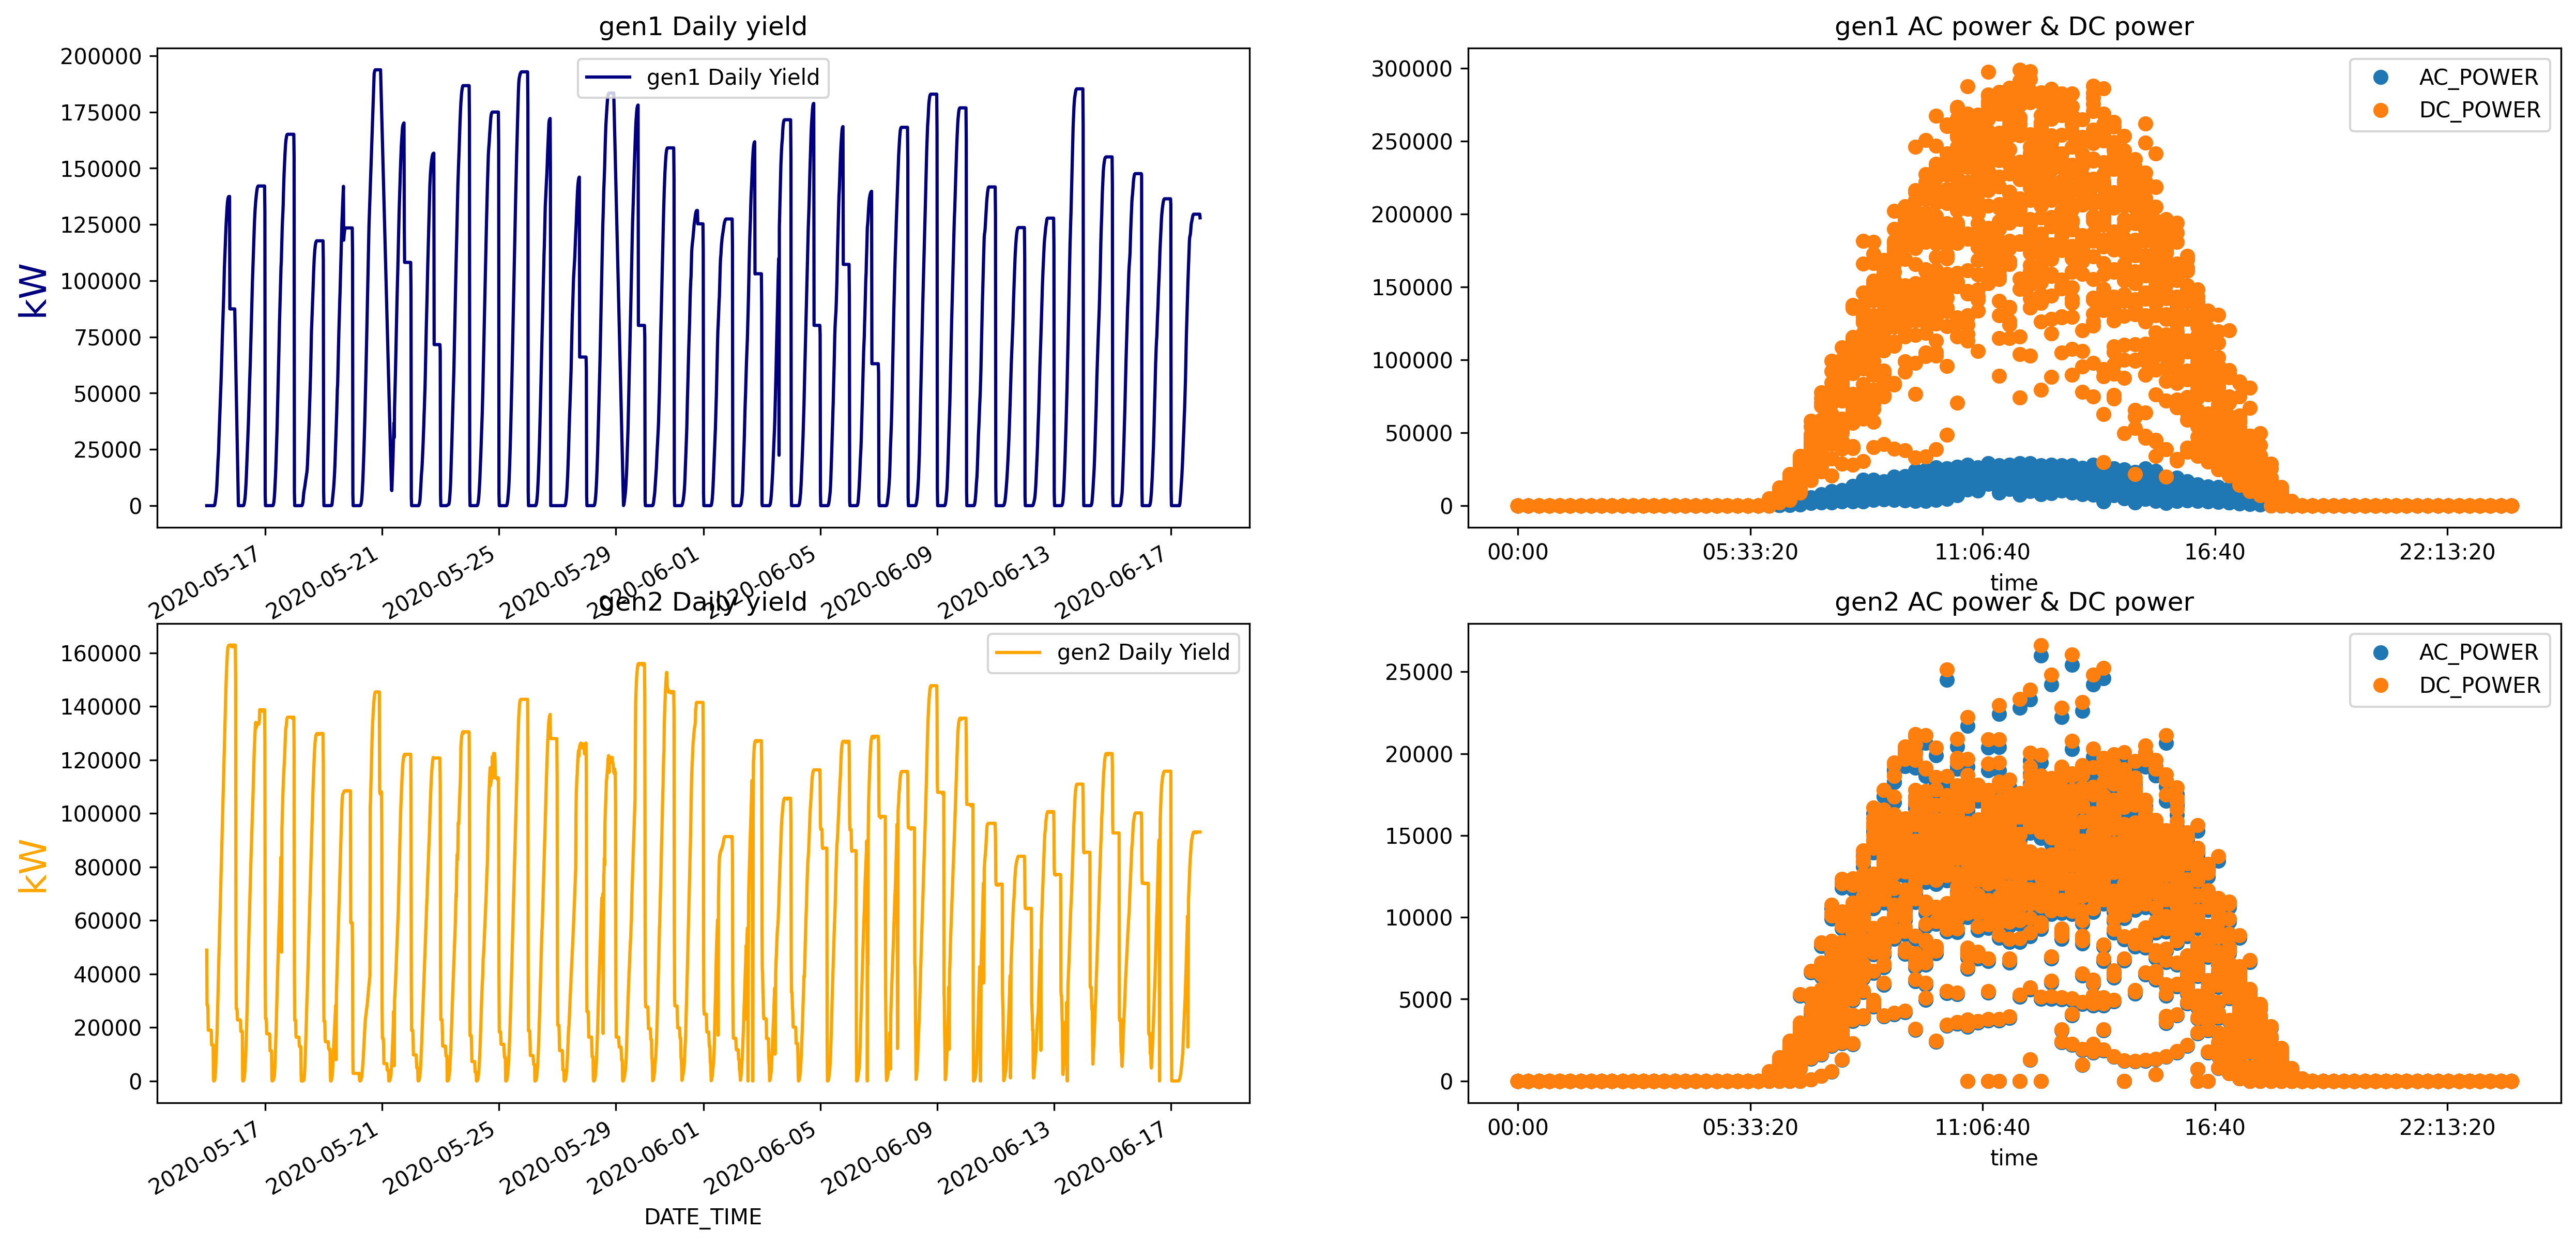

In [82]:
gen1 = p1gen.groupby("DATE_TIME").sum().reset_index()
gen1["time"]=gen1["DATE_TIME"].dt.time
gen2 = p2gen.groupby("DATE_TIME").sum().reset_index()
gen2["time"]=gen2["DATE_TIME"].dt.time


# Plot erstellen: 2 Zeilen, 2 Spalten
fig, ax = plt.subplots(ncols=2, nrows=2, dpi=300, figsize=(20, 10))

# Daily yield plot für gen1 (erste Zeile, erste Spalte)
gen1.plot(x='DATE_TIME', y='DAILY_YIELD', color='navy', ax=ax[0, 0], label='gen1 Daily Yield')
ax[0, 0].set_title('gen1 Daily yield')
ax[0, 0].set_ylabel('kW', color='navy', fontsize=17)
ax[0, 0].legend()

# AC & DC power plot für gen1 (erste Zeile, zweite Spalte)
gen1.set_index('time').drop('DATE_TIME', axis=1)[['AC_POWER', 'DC_POWER']].plot(style='o', ax=ax[0, 1], label='gen1 AC & DC Power')
ax[0, 1].set_title('gen1 AC power & DC power')
ax[0, 1].legend()

# Daily yield plot für gen2 (zweite Zeile, erste Spalte)
gen2.plot(x='DATE_TIME', y='DAILY_YIELD', color='orange', ax=ax[1, 0], label='gen2 Daily Yield')
ax[1, 0].set_title('gen2 Daily yield')
ax[1, 0].set_ylabel('kW', color='orange', fontsize=17)
ax[1, 0].legend()

# AC & DC power plot für gen2 (zweite Zeile, zweite Spalte)
gen2.set_index('time').drop('DATE_TIME', axis=1)[['AC_POWER', 'DC_POWER']].plot(style='o', ax=ax[1, 1], label='gen2 AC & DC Power')
ax[1, 1].set_title('gen2 AC power & DC power')
ax[1, 1].legend()

# Anzeige der Plots
plt.show()